In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = 'rock_paper_scissors/train'

transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

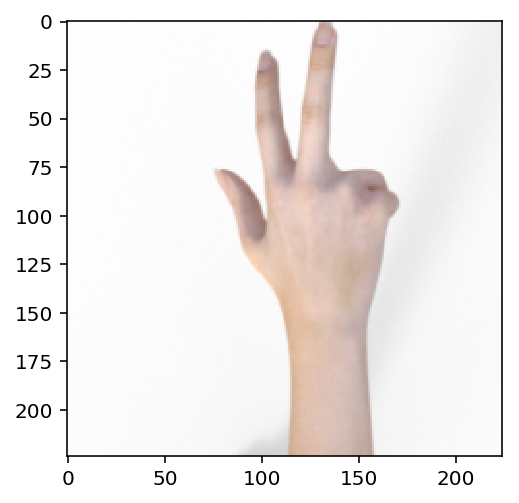

In [3]:
images, labels = next(iter(dataloader))
fig, ax = plt.subplots()
image = images[0].numpy().transpose((1, 2, 0))
ax.imshow(image)

In [4]:
image.shape

(224, 224, 3)

In [5]:
data_dir = 'rock_paper_scissors'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

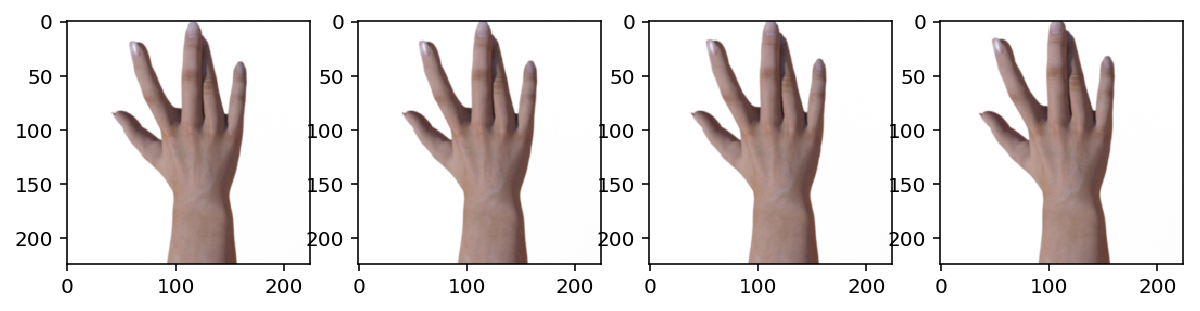

In [6]:
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    image = images[ii].numpy().transpose((1, 2, 0))
    ax.imshow(image)

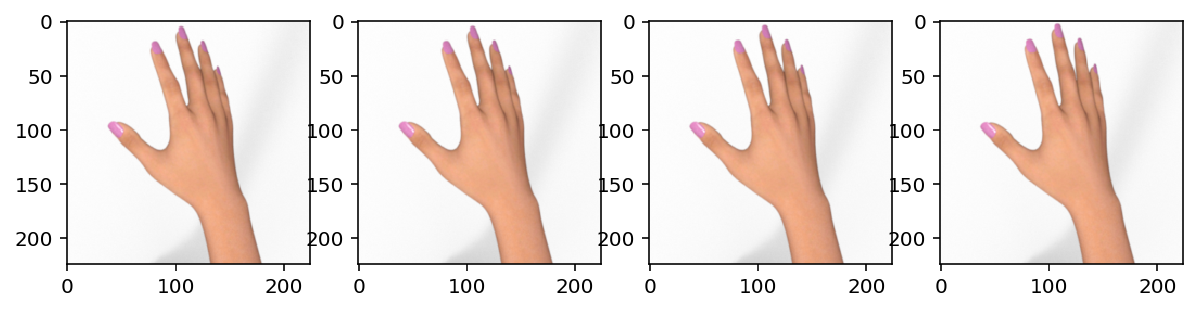

In [7]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    image = images[ii].numpy().transpose((1, 2, 0))
    ax.imshow(image)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 3)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 14 * 14)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.25)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        steps += 1
        
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in testloader:
                    optimizer.zero_grad()
                    output = model(images)
                    batch_loss = criterion(output, labels)
                    
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                    from sklearn.metrics import accuracy_score
                    accuracy += accuracy_score(labels.view(*top_class.shape), top_class)
                    
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(trainloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 0.116.. Test loss: 60.248.. Test accuracy: 0.323
Epoch 1/10.. Train loss: 0.000.. Test loss: 167.159.. Test accuracy: 0.323
Epoch 1/10.. Train loss: 399.287.. Test loss: 14.700.. Test accuracy: 0.323
Epoch 1/10.. Train loss: 13.631.. Test loss: 0.409.. Test accuracy: 0.323
Epoch 1/10.. Train loss: 0.017.. Test loss: 2.111.. Test accuracy: 0.323
Epoch 1/10.. Train loss: 9.882.. Test loss: 0.213.. Test accuracy: 0.323
Epoch 1/10.. Train loss: 1.204.. Test loss: 0.167.. Test accuracy: 0.354
Epoch 2/10.. Train loss: 0.398.. Test loss: 0.346.. Test accuracy: 0.354
Epoch 2/10.. Train loss: 2.127.. Test loss: 0.167.. Test accuracy: 0.354
Epoch 2/10.. Train loss: 0.607.. Test loss: 0.432.. Test accuracy: 0.323
Epoch 2/10.. Train loss: 2.476.. Test loss: 0.486.. Test accuracy: 0.323
Epoch 2/10.. Train loss: 1.336.. Test loss: 0.181.. Test accuracy: 0.323
Epoch 2/10.. Train loss: 0.633.. Test loss: 0.296.. Test accuracy: 0.323
Epoch 2/10.. Train loss: 2.470.. Test loss: 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model(img))

helper.view_classify(img, ps, version='rps')